## 0. Goal
Run VAE first to reduce spectrogram dimensions from 128*128 to 32 latent features. Then run UMAP and HDBSCAN. <br>
Use Goffinet spectrogramming and VAE network. <br>
Differ from v4: vary the min_samples of HDBSCAN

In [1]:
import os, sys, importlib, librosa, glob, h5py, tqdm
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import calinski_harabasz_score

plt.rcParams['pdf.fonttype'] = 42 

In [2]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import hopkins2
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)
importlib.reload(hopkins2)

<module 'hopkins2' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/hopkins2.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [4]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
birdIDs = ['pair5RigCCU29', 'pair4RigACU68', 'pair4RigBCU53', 'pair2RigBCU25']
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clims = [[1.5,7], [1.5,7], [1.5,8.5], [1.5,8]]
# what syllable to analyze
syl = ['v']
sylStr = ''.join(syl)
# the default color list
col_list = ['#e41a1c','#a65628','#4daf4a','#984ea3','#ff7f00','#f781bf','#377eb8','#737373']
# what input dataset to use: real and matched shuffle
input_rn = 'spec_goffinet_nn_256_176'
# size of the spectrogram windows
X_SHAPE = [128, 128]

In [5]:
# parameters to vary
hdbscan_min_sample = [10, 20, 30]
hdbscan_min_cluster = [0.05, 0.02]

In [6]:
# fixed paramteres for UMAP and HDBSCAN
param_umap = {'n_components':2, 'n_neighbors':25, 'min_dist':0, 'metric':'euclidean'}
# param_hdbscan = {'min_cluster_size_frac':0.05, 'min_samples': 20}

## 2. Loop through birds: VAE -> UMAP -> HDBSCAN

In [7]:
# save metrics in a master dataframe
metrics = pd.DataFrame()

Save results to /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair4RigACU68/UMAPonVAE5/v
(36359, 32) (36359, 7)
UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Tue Jun 10 10:29:48 2025 Construct fuzzy simplicial set
Tue Jun 10 10:29:48 2025 Finding Nearest Neighbors
Tue Jun 10 10:29:48 2025 Building RP forest with 15 trees
Tue Jun 10 10:29:48 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Tue Jun 10 10:29:50 2025 Finished Nearest Neighbor Search
Tue Jun 10 10:29:50 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Jun 10 10:30:05 2025 Finished embedding
The fraction that are not clustered: 0.1971
Total number of clusters: 6
Hopkins metric in UMAP: 0.9838
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: 0.3356
HDBSCAN Silhouette score in VAE: 0.0004
Calinski–Harabasz index in UMAP: 16200.9187
Calinski–Harabasz index in VAE: 1302.7604
The fraction that are not clustered: 0.1295
Total number of clusters: 13
Hopkins metric in UMAP: 0.9838
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: 0.3581
HDBSCAN Silhouette score in VAE: 0.0143
Calinski–Harabasz index in UMAP: 22648.8334
Calinski–Harabasz index in VAE: 1029.2430
The fraction that are not clustered: 0.1887
Total n

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Tue Jun 10 10:32:45 2025 Finished Nearest Neighbor Search
Tue Jun 10 10:32:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Jun 10 10:32:52 2025 Finished embedding
The fraction that are not clustered: 0.1476
Total number of clusters: 6
Hopkins metric in UMAP: 0.9697
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: 0.3700
HDBSCAN Silhouette score in VAE: 0.0003
Calinski–Harabasz index in UMAP: 8914.5859
Calinski–Harabasz index in VAE: 582.5263
The fraction that are not clustered: 0.1625
Total number of clusters: 8
Hopkins metric in UMAP: 0.9697
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: 0.2704
HDBSCAN Silhouette score in VAE: -0.0289
Calinski–Harabasz index in UMAP: 6282.2860
Calinski–Harabasz index in VAE: 460.1235
The fraction that are not clustered: 0.2039
Total numbe

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Tue Jun 10 10:33:34 2025 Finished Nearest Neighbor Search
Tue Jun 10 10:33:34 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Jun 10 10:33:41 2025 Finished embedding
The fraction that are not clustered: 0.0058
Total number of clusters: 3
Hopkins metric in UMAP: 0.9849
Hopkins metric in VAE: 0.8310
HDBSCAN Silhouette score in UMAP: 0.4503
HDBSCAN Silhouette score in VAE: 0.0325
Calinski–Harabasz index in UMAP: 14335.3560
Calinski–Harabasz index in VAE: 864.1092
The fraction that are not clustered: 0.0105
Total number of clusters: 4
Hopkins metric in UMAP: 0.9849
Hopkins metric in VAE: 0.8310
HDBSCAN Silhouette score in UMAP: 0.3709
HDBSCAN Silhouette score in VAE: 0.0249
Calinski–Harabasz index in UMAP: 12934.2882
Calinski–Harabasz index in VAE: 771.8890
The fraction that are not clustered: 0.0058
Total numb

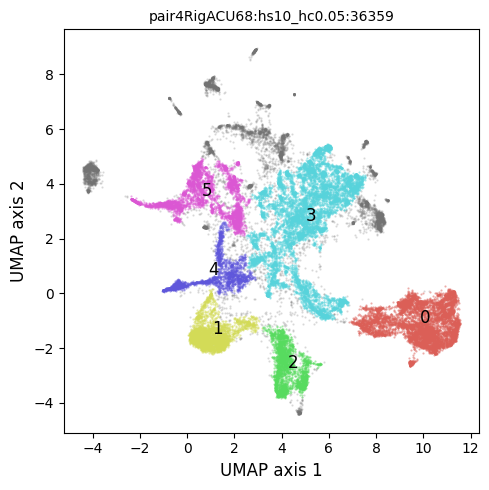

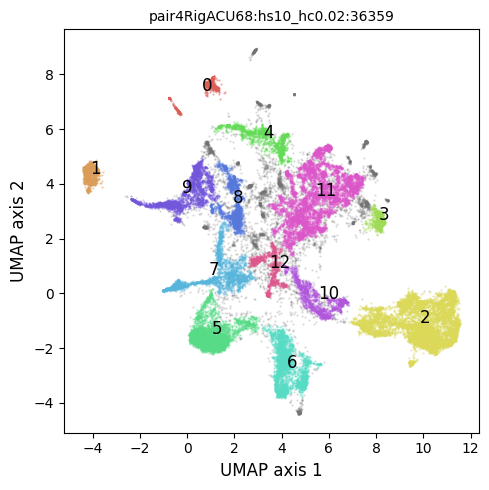

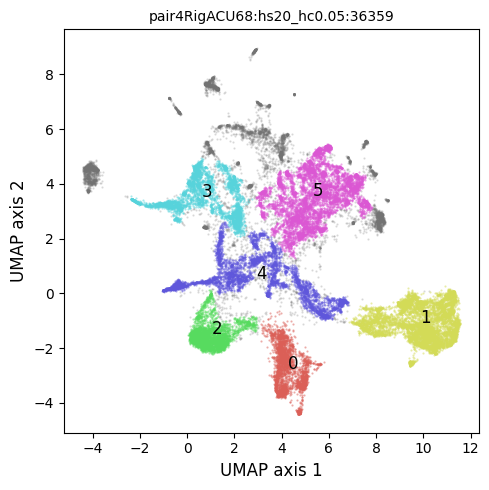

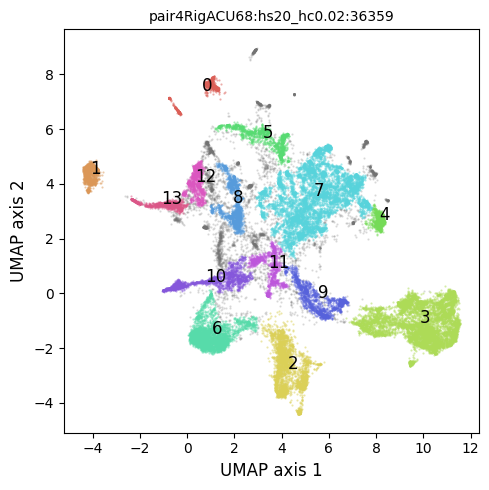

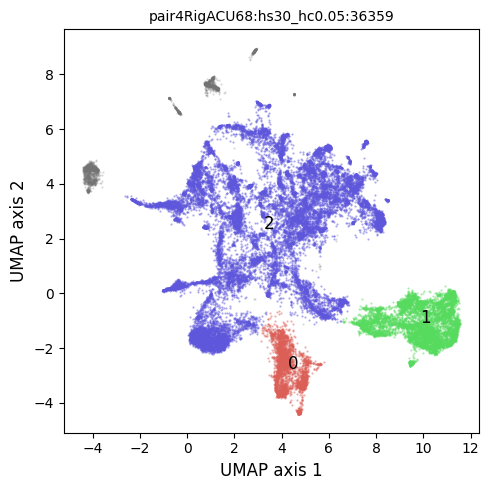

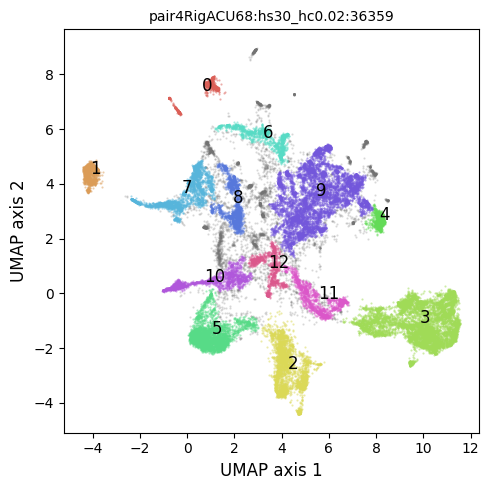

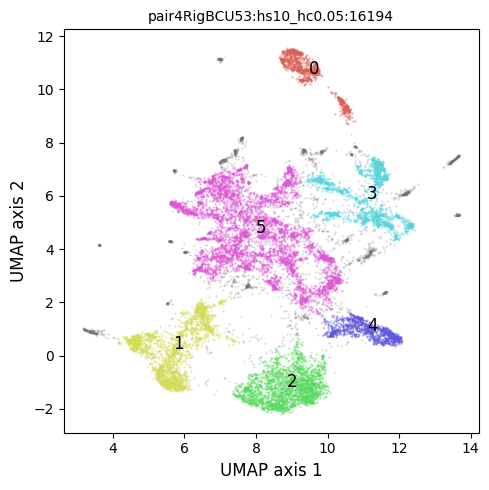

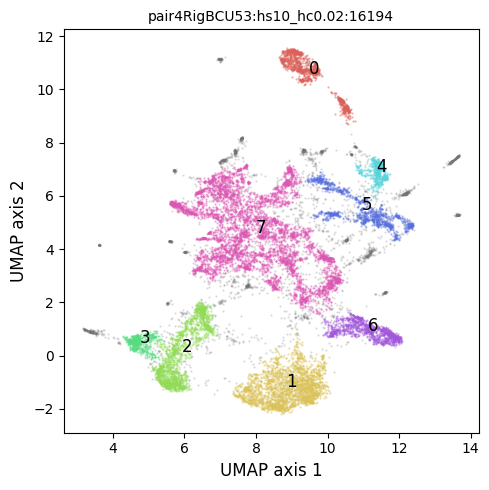

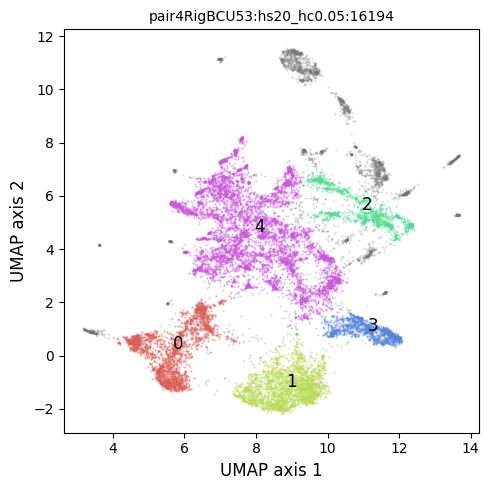

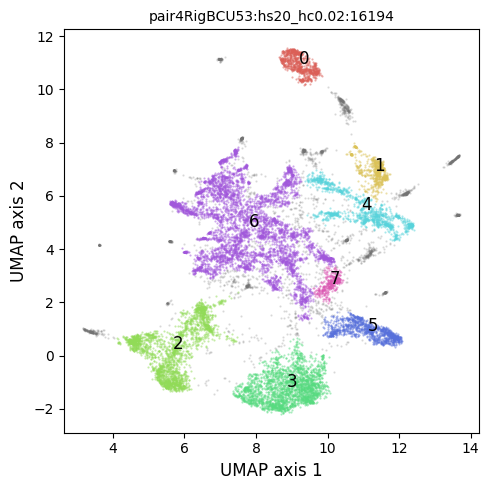

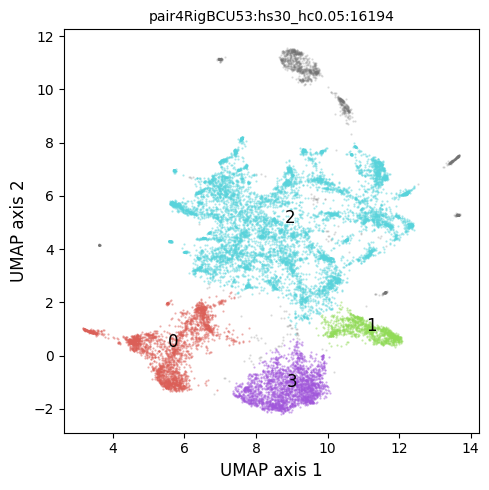

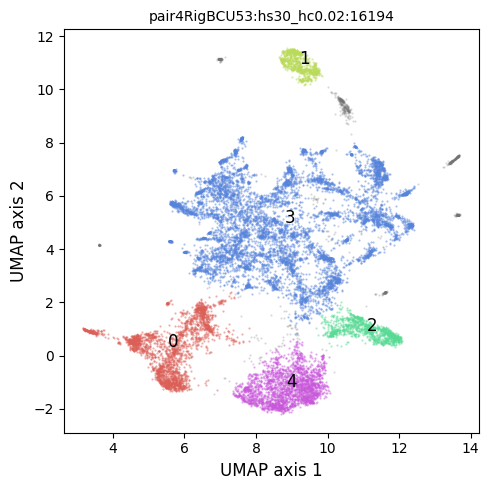

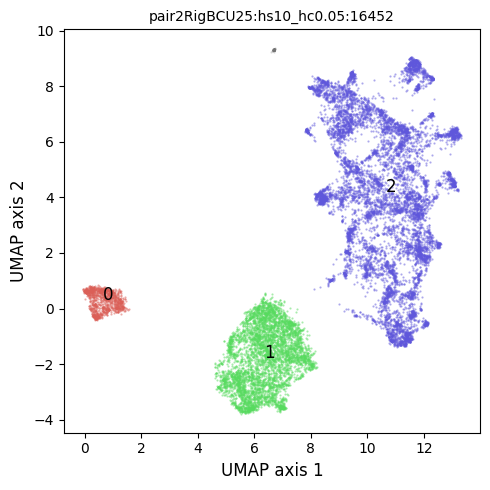

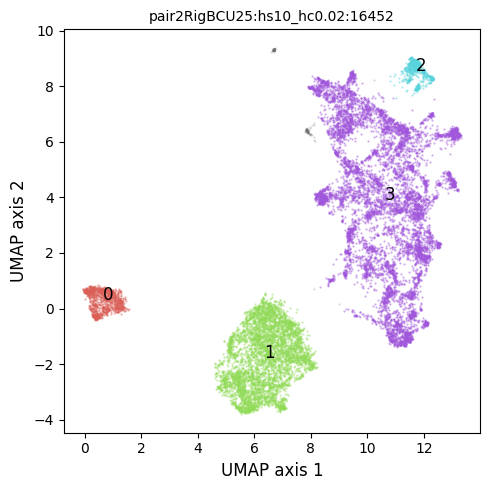

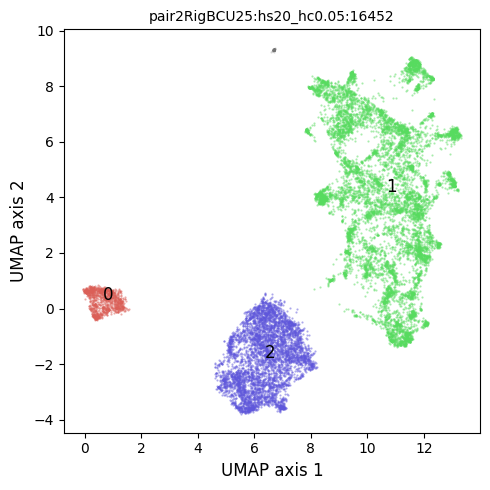

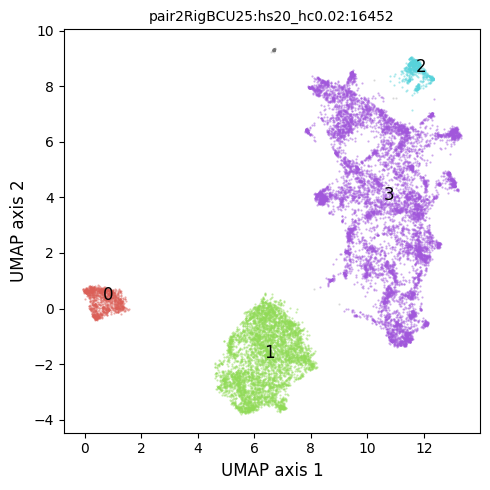

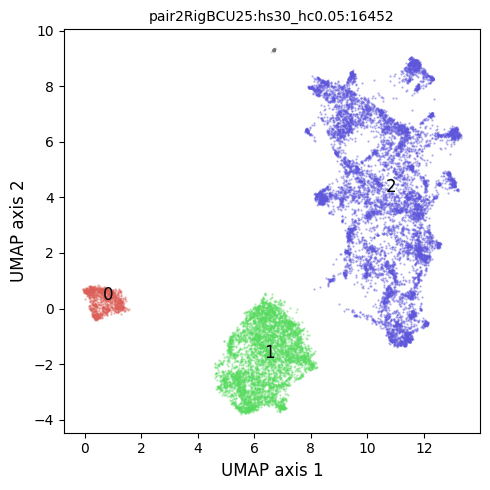

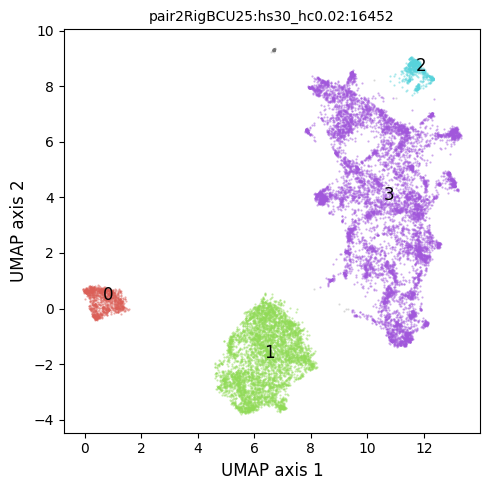

In [11]:
# loop through birds
for bi in range(1, len(birdIDs)):
# for bi in range(1):
    bd = birdIDs[bi]
    # save to a separate folder
    fd_save = os.path.join(fd_data, bd, 'UMAPonVAE5', sylStr)
    if not os.path.exists(fd_save):
        os.makedirs(fd_save)
    print(f'Save results to {fd_save}')
    # load VAE latent features and meta info
    fn_latent = os.path.join(fd_data, bd, 'UMAPonVAE1', sylStr, input_rn, 'latentM.csv')
    latent_m = np.loadtxt(fn_latent, delimiter=',')
    fn_info = os.path.join(fd_data, bd, 'Spectrogram2', sylStr, f'{bd}.{sylStr}.{input_rn}.info.csv')
    info = pd.read_csv(fn_info, index_col=0)
    print(latent_m.shape, info.shape)
    # add UMAP embedding to the dataframe
    embed_ori = info.copy()
    for ii in range(latent_m.shape[1]):
        embed_ori[f'vae{ii}'] = latent_m[:,ii]
    # loop through different parameters
    run_names = []
    
    # run UMAP
    umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                                  metric=param_umap['metric'], random_state=1118, verbose=True)
    res = umap_model.fit_transform(latent_m)

    # add umap results to the dataframe
    for jj in range(res.shape[1]):
        embed_ori[f'umap{jj+1}'] = res[:,jj]
            
    # loop through differnt HDBSCAN parameters
    for hs in hdbscan_min_sample:
        for hc in hdbscan_min_cluster:
            # give it a run name
            rn = f'hs{hs}_hc{hc}'
            run_names.append(rn)
            embed = embed_ori.copy()
            ## HDBSCAN clustering
            clusterer = hdbscan.HDBSCAN(min_cluster_size=int(res.shape[0]* hc), min_samples=hs)
            # clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=20)
            clusterer.fit(res)
            embed['hdbscan_cluster'] = clusterer.labels_
            embed['hdbscan_prob'] = clusterer.probabilities_

            # save embedding and clustering 
            fn_embed = os.path.join(fd_save, f'{bd}.{rn}.UMAPonVAE.embedding.csv')
            embed.to_csv(fn_embed)

            # what's the fraction that's not clustered
            unc_f = embed[embed['hdbscan_cluster']==-1].shape[0] / embed.shape[0]
            print(f'The fraction that are not clustered: {unc_f:.4f}')
            num_c = max(embed['hdbscan_cluster']+1)
            print(f'Total number of clusters: {num_c}')

            # color calls according to hdbscan labels
            col_long = sns.color_palette('hls', n_colors=max(embed['hdbscan_cluster'])+1)
            # plot embedding
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
            for hi in range(-1, max(embed['hdbscan_cluster'])+1):
                embed_s = embed[embed['hdbscan_cluster']==hi]
                if hi==-1:
                    ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, color='#737373')
                else:
                    ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.5, color=col_long[hi])
                    # add syl label
                    ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), hi, fontsize=12)
            ax.set_title(f'{bd}:{rn}:{embed.shape[0]}', fontsize=10)
            ax.set_xlabel('UMAP axis 1', fontsize=12)
            ax.set_ylabel('UMAP axis 2', fontsize=12)
            plt.tight_layout()
            # save fig
            fn_fig = os.path.join(fd_save, f'{bd}.{rn}.UMAPonVAE.HBBSCAN.pdf')
            fig.savefig(fn_fig)

            ## Quantify clustering tendency
            # in UMAP space
            hpk1 = hopkins2.hopkins_statistic(res, rng=1992)
            print(f'Hopkins metric in UMAP: {hpk1:.4f}')
            # in VAE space
            hpk2 = hopkins2.hopkins_statistic(latent_m, rng=1992)
            print(f'Hopkins metric in VAE: {hpk2:.4f}')

            ## Quantify clustering quality with Silhoutte score
            # in UMAP space
            sil1 = silhouette_score(res, embed['hdbscan_cluster'], random_state=1118, metric='euclidean')
            print(f'HDBSCAN Silhouette score in UMAP: {sil1:.4f}')
            # in VAE space
            sil2 = silhouette_score(latent_m, embed['hdbscan_cluster'], random_state=1118, metric='euclidean')
            print(f'HDBSCAN Silhouette score in VAE: {sil2:.4f}')

            # Calinski–Harabasz (CH) Index
            cah1 = calinski_harabasz_score(res, embed['hdbscan_cluster'])
            print(f'Calinski–Harabasz index in UMAP: {cah1:.4f}')
            cah2 = calinski_harabasz_score(latent_m, embed['hdbscan_cluster'])
            print(f'Calinski–Harabasz index in VAE: {cah2:.4f}')

            # save data to the master data frame
            row = pd.DataFrame([{'birdID':bd, 'run_name':rn, 'num_cluster':num_c, 'frac_unclustered':unc_f, 'cluster_persist':clusterer.cluster_persistence_, 'hopkins_umap':hpk1, 
                                 'hopkins_vae':hpk2, 'silhouette_umap':sil1, 'silhouette_vae':sil2, 'calinski_umap':cah1, 'calinski_vae':cah2, 'param_umap':param_umap}])
            metrics = pd.concat([metrics, row], ignore_index=True)

In [12]:
# save the metrics
fn_metric = os.path.join(fd_save, 'UMAPonVAE.metrics.csv')
metrics.to_csv(fn_metric)
metrics

,birdID,run_name,num_cluster,frac_unclustered,cluster_persist,hopkins_umap,hopkins_vae,silhouette_umap,silhouette_vae,calinski_umap,calinski_vae,param_umap
0,pair5RigCCU29,hs10_hc0.05,6,0.116480,"[0.2541242232437783, 0.22885675726298046, 0.44...",0.985925,0.860745,0.393713,0.028302,18917.793939,987.293336,"{'n_components': 2, 'n_neighbors': 25, 'min_di..."
1,pair5RigCCU29,hs10_hc0.02,7,0.081454,"[0.31242453033870754, 0.2078123548539258, 0.13...",0.985925,0.860745,0.388363,0.028641,18170.321204,914.740715,"{'n_components': 2, 'n_neighbors': 25, 'min_di..."
2,pair5RigCCU29,hs20_hc0.05,6,0.113124,"[0.15763438657619475, 0.318731627070003, 0.384...",0.985925,0.860745,0.368774,0.007379,13935.022315,894.482821,"{'n_components': 2, 'n_neighbors': 25, 'min_di..."
3,pair5RigCCU29,hs20_hc0.02,7,0.086274,"[0.23798264041730022, 0.12864856138584702, 0.2...",0.985925,0.860745,0.274080,0.004620,12825.082126,810.497426,"{'n_components': 2, 'n_neighbors': 25, 'min_di..."
4,pair5RigCCU29,hs30_hc0.05,2,0.003313,"[0.364775006549522, 0.6024427854245351]",0.985925,0.860745,0.494367,0.063800,15479.421920,1079.122003,"{'n_components': 2, 'n_neighbors': 25, 'min_di..."
5,pair5RigCCU29,hs30_hc0.02,2,0.003313,"[0.2976164362815526, 0.49152730215149976]",0.985925,0.860745,0.494367,0.063800,15479.421920,1079.122003,"{'n_components': 2, 'n_neighbors': 25, 'min_di..."
6,pair4RigACU68,hs10_hc0.05,6,0.197090,"[0.5500006738649207, 0.548226978428397, 0.2702...",0.983814,0.850167,0.335592,0.000395,16200.918689,1302.760402,"{'n_components': 2, 'n_neighbors': 25, 'min_di..."
7,pair4RigACU68,hs10_hc0.02,13,0.129514,"[0.004033778941272235, 0.7913723690350148, 0.4...",0.983814,0.850167,0.358140,0.014344,22648.833365,1029.243030,"{'n_components': 2, 'n_neighbors': 25, 'min_di..."
8,pair4RigACU68,hs20_hc0.05,6,0.188674,"[0.4607926898236672, 0.4307462790363003, 0.496...",0.983814,0.850167,0.361994,0.013354,18939.537783,1498.197714,"{'n_components': 2, 'n_neighbors': 25, 'min_di..."
9,pair4RigACU68,hs20_hc0.02,14,0.113369,"[0.0030193024346462597, 0.7737993481109541, 0....",0.983814,0.850167,0.352201,0.013239,23219.056176,997.698137,"{'n_components': 2, 'n_neighbors': 25, 'min_di..."


## 3. Plot summary metrics

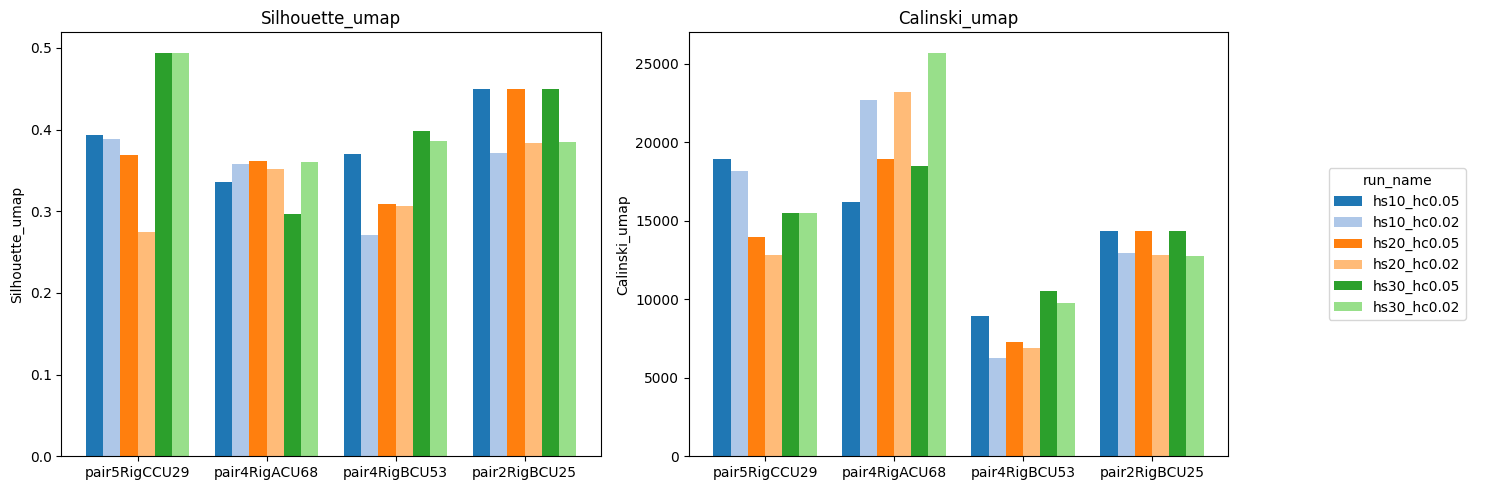

In [13]:
bird_ids = birdIDs
cmap = plt.get_cmap('tab20')
col_list = [cmap(i) for i in range(len(run_names))]
run_name_to_color = {run: col_list[i] for i, run in enumerate(run_names)}

# Setup
fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 0.3]})
metrics_to_plot = ['silhouette_umap', 'calinski_umap']
width = 0.8 / len(run_names)
x = np.arange(len(bird_ids))

# Plot loop
for ax, metric in zip(axes[:2], metrics_to_plot):
    for i, run in enumerate(run_names):
        vals = [
            metrics.loc[(metrics['birdID'] == bird) & (metrics['run_name'] == run), metric].values[0]
            if not metrics[(metrics['birdID'] == bird) & (metrics['run_name'] == run)].empty else np.nan
            for bird in bird_ids
        ]
        ax.bar(x + i * width, vals, width, label=run, color=run_name_to_color[run])
    ax.set_title(metric.capitalize())
    ax.set_xticks(x + width * (len(run_names) - 1) / 2)
    ax.set_xticklabels(bird_ids)
    ax.set_ylabel(metric.capitalize())

# Legend in third panel
axes[2].axis('off')  # Hide axis
handles, labels = axes[0].get_legend_handles_labels()
axes[2].legend(handles, labels, title='run_name', loc='center')

plt.tight_layout()
plt.show()

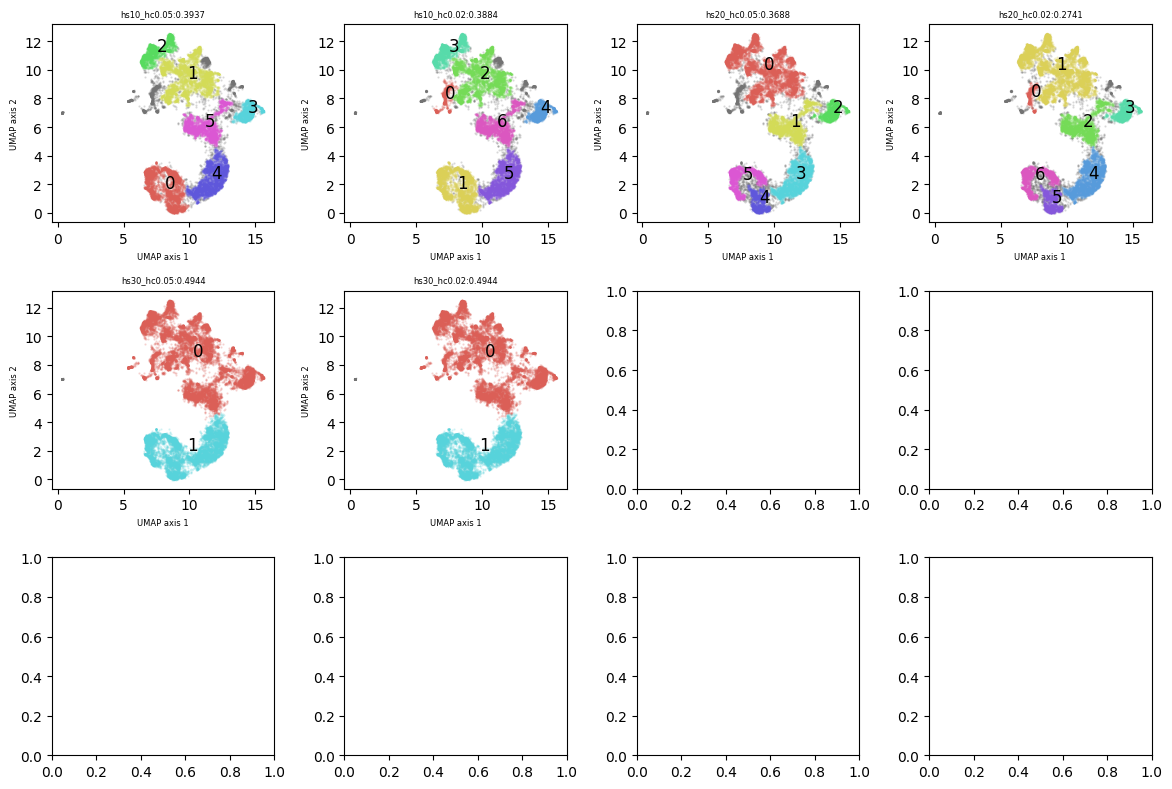

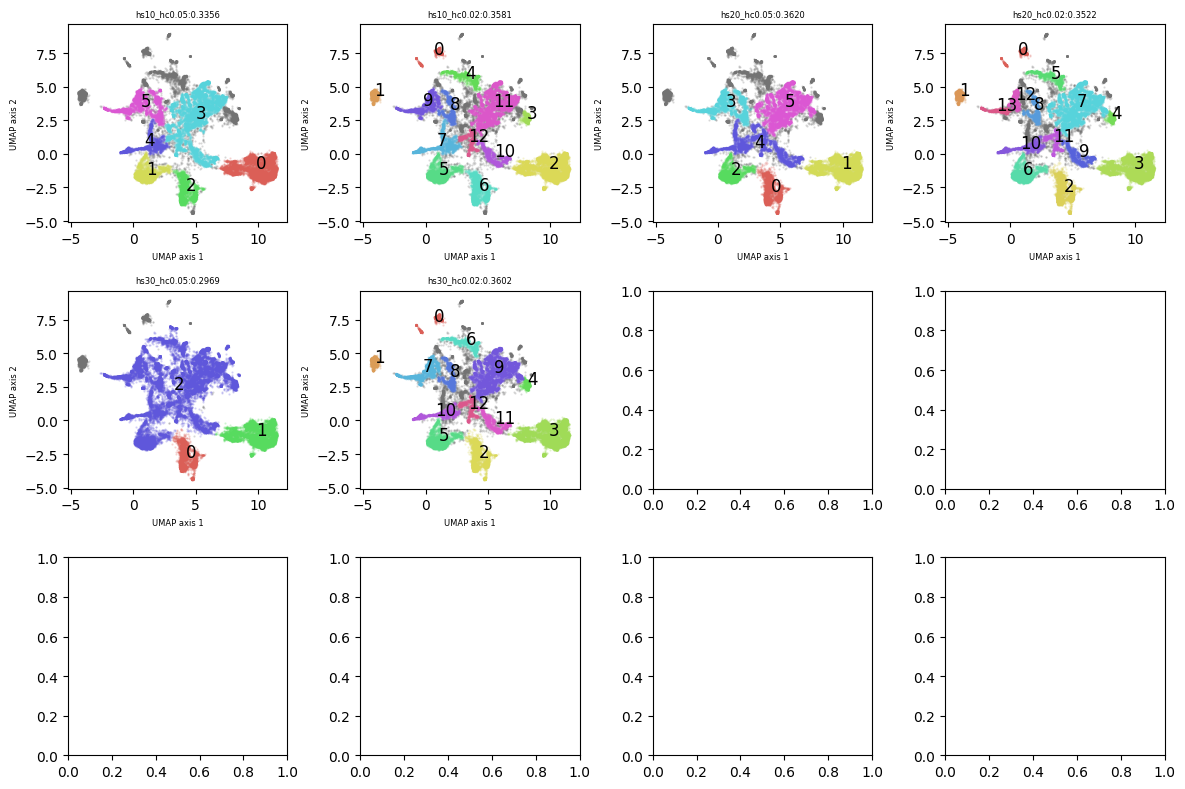

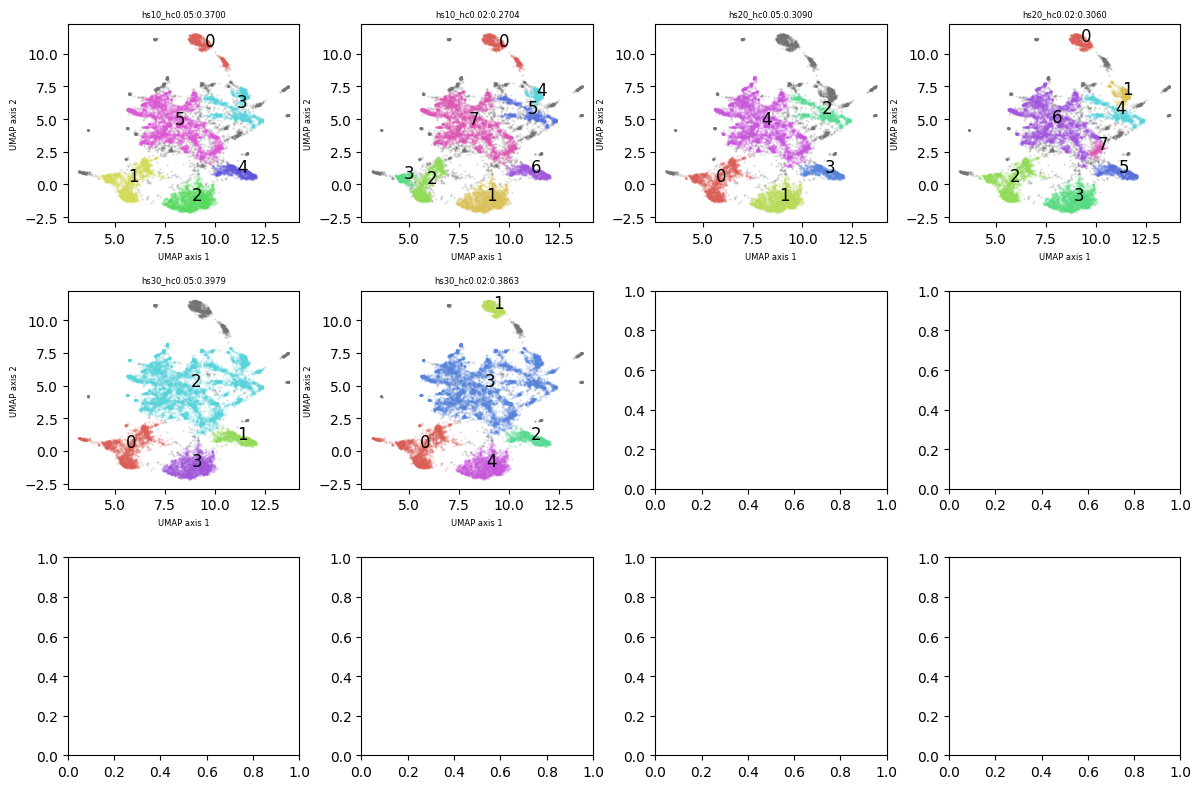

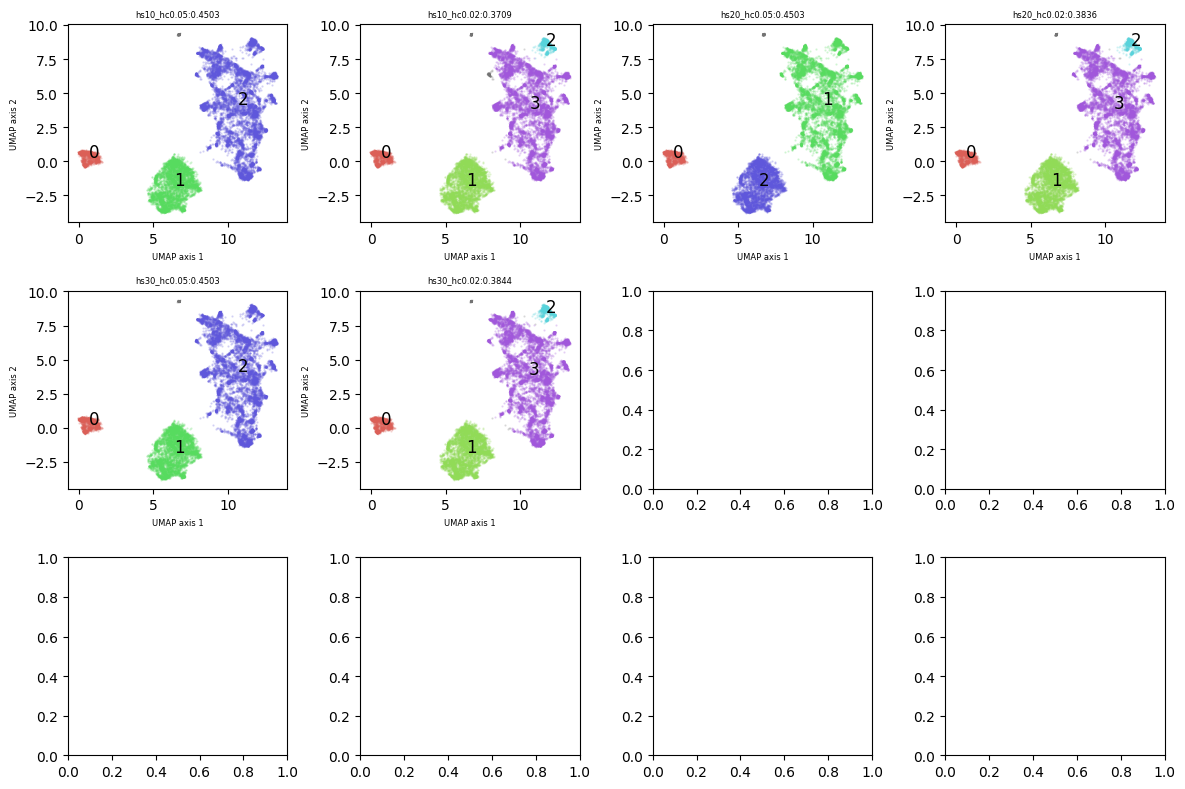

In [15]:
# Combine the HDBSCAN clustering plot
# bi = 0
for bi in range(len(birdIDs)):
# for bi in range(1):
    bd = birdIDs[bi]
    # one figure for each bird
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=[12, 8])

    for ri in range(len(run_names)):
        rn = run_names[ri]
        fd_save = os.path.join(fd_data, bd, 'UMAPonVAE5', sylStr)
        fn_embed = os.path.join(fd_save, f'{bd}.{rn}.UMAPonVAE.embedding.csv')
        embed = pd.read_csv(fn_embed, index_col=0)

        plot_i = ri//4
        plot_j = ri%4
        ax = axes[plot_i][plot_j]
        # color calls according to hdbscan labels
        col_long = sns.color_palette('hls', n_colors=max(embed['hdbscan_cluster'])+1)
        # plot embedding
        for hi in range(-1, max(embed['hdbscan_cluster'])+1):
            embed_s = embed[embed['hdbscan_cluster']==hi]
            if hi==-1:
                ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, color='#737373')
            else:
                ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, color=col_long[hi])
                # add syl label
                ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), hi, fontsize=12)
        sil = metrics.loc[(metrics['birdID'] == bd) & (metrics['run_name'] == rn), 'silhouette_umap'].iloc[0]
        ax.set_title(f'{rn}:{sil:.4f}', fontsize=6)
        ax.set_xlabel('UMAP axis 1', fontsize=6)
        ax.set_ylabel('UMAP axis 2', fontsize=6)
    plt.tight_layout()
    # save plot
    fn_fig = os.path.join(fd_save, f'{bd}.HDBSCANcomb.pdf')
    fig.savefig(fn_fig)